In [24]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, AveragePooling2D
from keras.optimizers import Adam
import cv2
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
import scipy.fftpack as fp
from skimage.io import imread
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


In [25]:
tp = pd.read_csv('tp_list.txt', header=None)
au = pd.read_csv('au_list.txt', header=None)
file_path_au = "C:\\Users\\jakub\\Desktop\\Au"
file_path_tp = "C:\\Users\\jakub\\Desktop\\Tp"
au[0] = file_path_au + "\\" + au[0]
tp[0] = file_path_tp + "\\" + tp[0]
au.columns = ['file_path']
tp.columns = ['file_path']
au['type'] = 'Authentic'
tp['type'] = 'Forged'

In [26]:
au = au.head(300)
tp = tp.head(300)

In [27]:
im_df = pd.concat([au, tp], ignore_index=True)

In [28]:
def preprocess_image(image_path, output_size=(224, 224)):
    # Wczytanie obrazu w trybie kolorowym (RGB)
    img_rgb = cv2.imread(image_path)
    if img_rgb is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    img_rgb = cv2.resize(img_rgb, output_size)  # Skalowanie do (224, 224)

    # Przygotowanie pustego obrazu do przechowywania przetworzonych kanałów
    processed_channels = []

    for channel in cv2.split(img_rgb):  # Przetwarzanie każdego kanału RGB
        # Konwersja do float32
        channel_float = np.float32(channel)

        # Transformata Fouriera
        dft = cv2.dft(channel_float, flags=cv2.DFT_COMPLEX_OUTPUT)
        dft_shift = np.fft.fftshift(dft)

        # Tworzenie maski HPF
        rows, cols = channel.shape
        crow, ccol = rows // 2, cols // 2
        mask = np.ones((rows, cols, 2), np.float32)
        r = 64  # Promień maski
        x, y = np.ogrid[:rows, :cols]
        mask_area = (x - crow) ** 2 + (y - ccol) ** 2 <= r*r
        mask[mask_area] = 0

        # Zastosowanie maski
        fshift = dft_shift * mask

        # Transformata odwrotna
        f_ishift = np.fft.ifftshift(fshift)
        img_back = cv2.idft(f_ishift)
        img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

        # Normalizacja do zakresu [0, 255]
        img_normalized = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
        img_normalized = np.uint8(img_normalized)  # Konwersja na typ uint8

        # Dodanie przetworzonego kanału do listy
        processed_channels.append(img_normalized)

    # Scalanie kanałów w jeden obraz RGB
    img_processed = cv2.merge(processed_channels)

    return img_processed


In [29]:
def save_image():
    labels = []
    imgs = []
    
    for i in range(len(im_df)):
        labels.append(im_df['type'][i]) 
        img_normalized = preprocess_image(im_df['file_path'][i]) 
        imgs.append(img_normalized)
    
    return labels, imgs

In [30]:
#odzyskiwanie ramu
del tp
del au
del file_path_au
del file_path_tp

In [31]:
labels, imgs = save_image()

In [32]:
#odzyskiwanie ramu
del im_df

In [33]:
u = list(np.unique(labels)) #lsita unikalnych wartości w labels (red, green, other)

ilabels = np.asarray([u.index(l) for l in labels]) #utworzenie nowej listy zawierającyh wartości unikalne w postaci liczb, a nie tekstu

In [34]:
#odzyskiwanie ramu
del u
del labels

Kodu niżej nie uruchmiać jeśli nie ma się 32 GB RAMU, bo freezuje komputer

In [35]:
X = np.stack(imgs) / 255.0 - 0.5 #połączenie wszystkich osobnych list zawarty w imgs w jedną podzielenie wartości przez 255, ay otrzymać wartości od 0 do 1 i pomniejszenie wartości o 0.5 i otrzymanie od -0.5 do 0.5

In [36]:
del imgs

In [37]:

X_train, X_test, y_train, y_test = train_test_split(X, ilabels, test_size=0.2, shuffle=True, random_state=42) #podzielenie danych na treningowe i testowe, jak wyżej


In [38]:
del X
del ilabels

In [41]:
# Tworzenie modelu Sequential
input_shape = (224, 224, 3)

# Define the CNN model
model = Sequential([
        # Input layer with Conv2D
        Conv2D(filters=25, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name='conv2d'),

        # MaxPooling 
        MaxPooling2D(pool_size=(2, 2), strides=(1, 1),  padding='same', name='max_pooling2d'),

        # Flatten layer
        Flatten(name='flatten'),

        # Fully connected Dense layers
        Dense(100, activation='relu', name='dense'),
        Dense(100, activation='relu', name='dense_1'),
        Dense(100, activation='relu', name='dense_2'),

        # Output layer
        Dense(1, activation='sigmoid', name='dense_3')
])

# Kompilacja modelu z dodatkowymi metrykami
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=1e-3), 
              metrics=['accuracy', AUC(name="AUC"), Precision(name="Precision"), Recall(name="Recall"), keras.metrics.TruePositives(name="TP"), keras.metrics.TrueNegatives(name="TN")])
            
# Podsumowanie modelu
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 25)   │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 222, 222, 25)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1232100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │   123,210,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,231,101 (470.09 MB)

 Trainable params: 123,231,101 (470.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
h = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=2, validation_data=(X_test, y_test), callbacks=EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=False ))

Epoch 1/100
15/15 - 29s - 2s/step - AUC: 0.5069 - Precision: 0.5138 - Recall: 0.5372 - TN: 115.0000 - TP: 130.0000 - accuracy: 0.5104 - loss: 8.6547 - val_AUC: 0.5000 - val_Precision: 0.4833 - val_Recall: 1.0000 - val_TN: 0.0000e+00 - val_TP: 58.0000 - val_accuracy: 0.4833 - val_loss: 3.0721
Epoch 2/100
15/15 - 22s - 1s/step - AUC: 0.5240 - Precision: 0.5172 - Recall: 0.5579 - TN: 112.0000 - TP: 135.0000 - accuracy: 0.5146 - loss: 1.4553 - val_AUC: 0.7314 - val_Precision: 1.0000 - val_Recall: 0.0172 - val_TN: 62.0000 - val_TP: 1.0000 - val_accuracy: 0.5250 - val_loss: 0.7831
Epoch 3/100
15/15 - 23s - 2s/step - AUC: 0.7393 - Precision: 0.6952 - Recall: 0.6033 - TN: 174.0000 - TP: 146.0000 - accuracy: 0.6667 - loss: 0.6024 - val_AUC: 0.7382 - val_Precision: 0.6125 - val_Recall: 0.8448 - val_TN: 31.0000 - val_TP: 49.0000 - val_accuracy: 0.6667 - val_loss: 0.6441
Epoch 4/100


KeyboardInterrupt: 

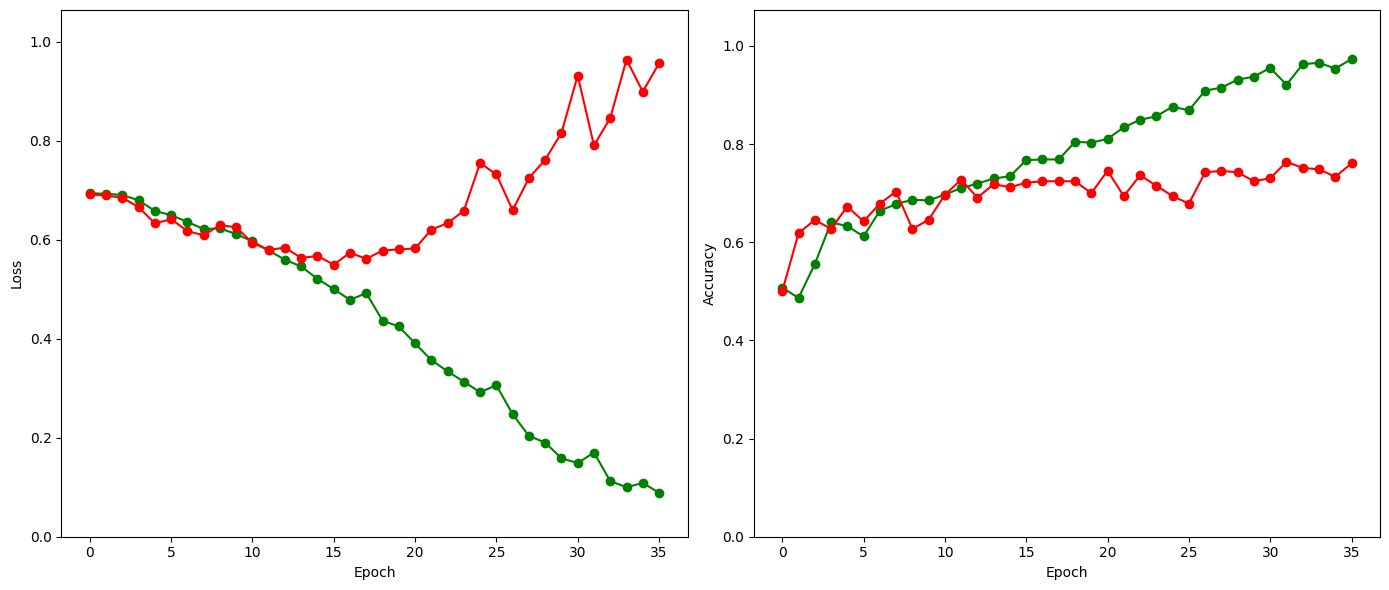

Training history with confidence intervals saved as training_history_with_ci.svg


In [49]:
# Tworzenie DataFrame z historii trenowania
history_df = pd.DataFrame(h.history)

# Obliczanie przedziałów ufności (np. 95%)
confidence_interval = 0.95
ci_bounds = int((1 - confidence_interval) * 100 / 2)

# Funkcja do obliczania przedziału ufności
def compute_confidence_interval(values):
    mean = np.mean(values)
    std = np.std(values)
    ci_range = std * 1.96  # 95% przedział ufności
    return mean - ci_range, mean + ci_range

# Tworzenie wykresów
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Wykres dla loss
axes[0].plot(history_df['loss'], label='Loss', color='green', marker='o')
axes[0].plot(history_df['val_loss'], label='Loss', color='red', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_ylim(0, max(history_df[['loss', 'val_loss']].max()) + 0.1)  # Skala od 0

# Wykres dla accuracy
axes[1].plot(history_df['accuracy'], label='Accuracy', color='green', marker='o')
axes[1].plot(history_df['val_accuracy'], label='Accuracy', color='red', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, max(history_df[['accuracy', 'val_accuracy']].max()) + 0.1)  # Skala od 0
# Zapis do pliku SVG
plt.tight_layout()
plt.savefig('training_history_with_ci.svg', format='svg')
plt.show()

print("Training history with confidence intervals saved as training_history_with_ci.svg")


In [50]:
history_df.to_csv('fft_rgb.csv', index=False)

In [51]:
history_df

,accuracy,auc_3,loss,precision_3,recall_3,val_accuracy,val_auc_3,val_loss,val_precision_3,val_recall_3
0,0.507463,0.514233,0.693887,0.507463,0.507463,0.500000,0.576258,0.691427,0.500000,0.500000
1,0.486567,0.517879,0.692655,0.486567,0.486567,0.618182,0.669550,0.689282,0.618182,0.618182
2,0.555224,0.559608,0.690340,0.555224,0.555224,0.645455,0.675620,0.684515,0.645455,0.645455
3,0.640298,0.665834,0.679622,0.640298,0.640298,0.627273,0.666465,0.666034,0.627273,0.627273
4,0.632836,0.674828,0.658149,0.632836,0.632836,0.672727,0.715354,0.632889,0.672727,0.672727
5,0.611940,0.670371,0.649521,0.611940,0.611940,0.642424,0.691993,0.641480,0.642424,0.642424
6,0.664179,0.700903,0.635944,0.664179,0.664179,0.678788,0.730556,0.617397,0.678788,0.678788
7,0.677612,0.727652,0.621494,0.677612,0.677612,0.703030,0.741800,0.608725,0.703030,0.703030
8,0.686567,0.717716,0.622920,0.686567,0.686567,0.627273,0.693985,0.629393,0.627273,0.627273
9,0.685075,0.732396,0.611341,0.685075,0.685075,0.645455,0.708508,0.625027,0.645455,0.645455


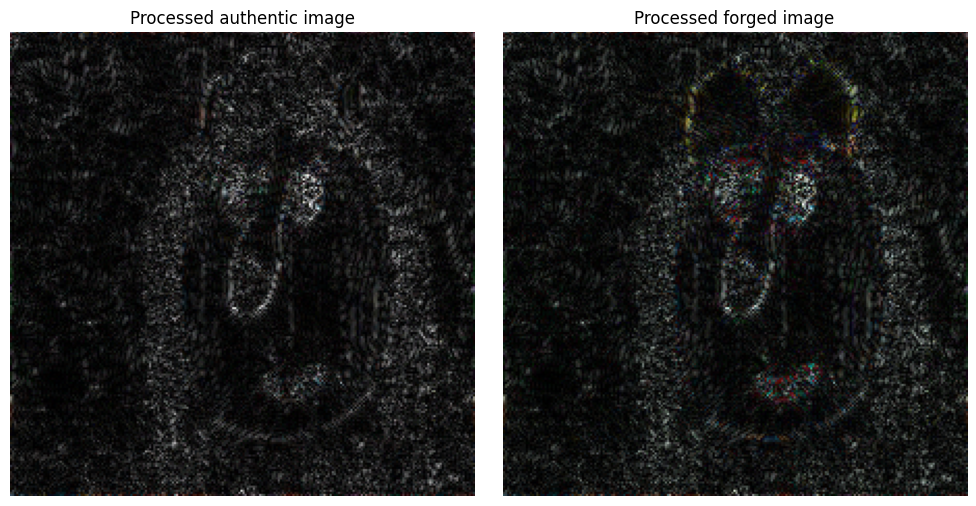

In [86]:
# Ścieżki do obrazów
image_path1 = 'F:\\github\\CASIA2.0_revised\\CASIA2.0_revised\\Au\\Au_art_00011.jpg'  # Zamień na właściwą ścieżkę do obrazu
image_path2 = 'F:\\github\\CASIA2.0_revised\\CASIA2.0_revised\\Tp\\Tp_D_CNN_S_N_art00011_art00014_11841.jpg'  # Zamień na właściwą ścieżkę do obrazu

# Przetwarzanie obrazów
processed_image1 = preprocess_image(image_path1)
processed_image2 = preprocess_image(image_path2)

# Wyświetlanie obrazów
plt.figure(figsize=(10, 5))

# Obraz 1
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(processed_image1, cv2.COLOR_BGR2RGB))
plt.title('Processed authentic image')
plt.axis('off')

# Obraz 2
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(processed_image2, cv2.COLOR_BGR2RGB))
plt.title('Processed forged image')
plt.axis('off')

plt.tight_layout()
plt.show()
